In [20]:
import numpy as np
from functions import *
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS, TSNE
from sklearn.datasets import load_digits
from sklearn import random_projection
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
from tqdm import tqdm
import umap
from sklearn.svm import SVC
import numpy as np
from sklearn.datasets import make_blobs


def alpha_quick(pts):
    #print( cdist([pts[-1]], pts[:-1]).shape)
    # this works for a configuration generates from our random cluster alpha configuration with one cluster
    return np.min(cdist([pts[-1]], pts[:-1])) / diam(pts[:-1])

# calculates the alpha-statistic of a point with respect to the other points
def alpha_(pts, ix):
    X = pts
    y = np.ones(len(pts))
    y[ix] = -1

    clf = SVC(kernel="linear", C=1e12)
    clf.fit(X,y)
    if np.all(clf.predict(X) == y):
        return 2 * (1.0 / np.linalg.norm(clf.coef_))/diam(pts[np.where(y==1)])
    else:
        return 0

def alpha(pts):
    max_margin = 0
    for i in range(len(pts)):
        x0 = np.asarray(pts[i]).reshape(1, -1)
        S = np.vstack([pts[:i], pts[i+1:]] )
        max_margin = min([max_margin, alpha_(x0, S)] ) 
    return max_margin

# caclulates the diameter of a set of points
def diam(pts):
    return max(pdist(pts, metric='euclidean'))

# k clusters with an alpha outlier
# for a single outlier, alpha is exact
# for more than one outlier, alpha is a lower bound
def create_cluster_outlier_config(alpha, n, k, d, num_outliers, std=1.0, rng=np.random.default_rng()):

    X, y = make_blobs(n_samples=n, centers=k, n_features=d, random_state=0, cluster_std=std)
    mu = X.mean(axis=0)

    for i in range(num_outliers):
        # pick random direction
        v = rng.normal(size=d)
        v /= np.linalg.norm(v)

        # project points relative to mu
        proj = (X - mu) @ v
        if i == 1:
            # use point with highest projection, for most accurate possible alpha
            j = np.argmax(proj[:n])
            v = (X[j] - mu) 
            v_unit = v / np.linalg.norm(v)

            outlier = mu + (np.linalg.norm(v) + alpha*diam(X))* v_unit 
        else:
            outlier = mu + (proj.max() + alpha*diam(X))*v 

        X = np.concatenate((X, np.array( [outlier])), axis=0)

    return X


computed alpha (using SVM)	 1.0220021080621553
true alpha 			 1.0


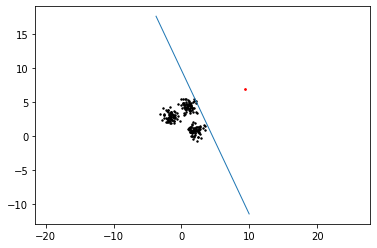

In [28]:
## 2d plot of an alpha-outlier configuration!
ALPHA = 1.0

X= create_cluster_outlier_config(alpha=ALPHA, n=200, k=3, d=2, num_outliers=1, std=0.6)
mu = np.mean(X[:-1], axis=0)
v = X[-1] - mu
v /= np.linalg.norm(v)
c = ((X[:-1] - mu) @ v).max()

barrier = mu + v*c

ax = plt.gca()
plt.scatter(X[:-1,0], X[:-1,1],c='black', s=2)
plt.scatter(X[-1,0], X[-1,1],c='red', s=3)
plt.axis('equal')

xlim = ax.get_xlim()
x_vals = np.linspace(xlim[0], xlim[1], 2)
y_vals = (-v[0]/v[1]) * (x_vals - barrier[0]) + barrier[1]
plt.plot(x_vals, y_vals, linewidth = 1)

print('computed alpha (using SVM)\t', alpha_quick(X))
print('true alpha \t\t\t', ALPHA)

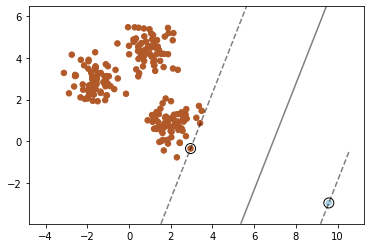

In [ ]:

X= create_cluster_outlier_config(alpha=ALPHA, n=200, k=3, d=2, num_outliers=1, std=0.6)

y = np.ones(len(X))
y[-1] = -1


<ipython-input-554-28b78cac423f>:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:-1, 0], X[:-1, 1], c='black', s=60, cmap=plt.cm.Paired)
<ipython-input-554-28b78cac423f>:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[-1, 0], X[-1, 1], c='red', s=60, cmap=plt.cm.Paired)


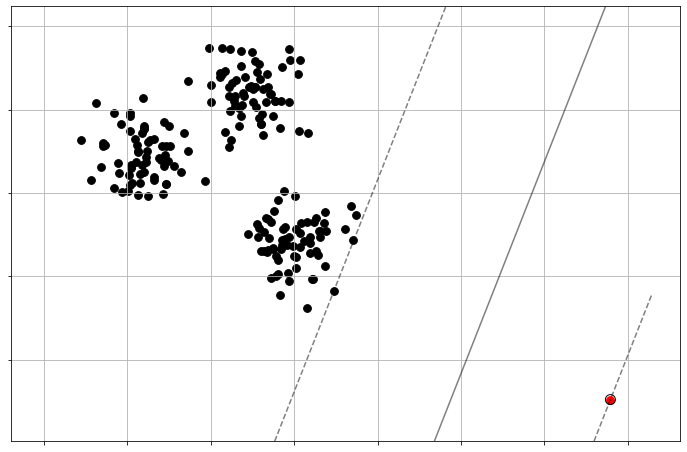

In [554]:
from sklearn.inspection import DecisionBoundaryDisplay

# fit the model, don't regularize for illustration purposes
clf = SVC(kernel="linear", C=1e12)
clf.fit(X, y)


plt.scatter(X[:-1, 0], X[:-1, 1], c='black', s=60, cmap=plt.cm.Paired)
plt.scatter(X[-1, 0], X[-1, 1], c='red', s=60, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
fig = ax.figure
fig.set_size_inches(12, 8)
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0][0],
    clf.support_vectors_[:, 1][0],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.axis('equal')
plt.grid('on')
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.savefig('visuals/outliers/illustrative_plot_.png')

plt.show()

5 clusters, 3 (alpha >= 0.2)-outliers


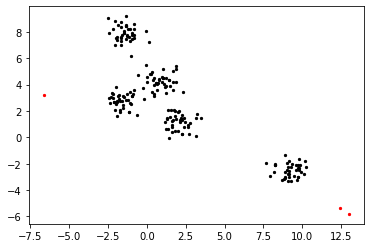

In [521]:
n_outliers  = 3
X= create_cluster_outlier_config(alpha=0.2, n=200, k=5, d=2, num_outliers=n_outliers, std=0.6)
plt.scatter(X[:-n_outliers,0],X[:-n_outliers,1], c='black', s=5)
plt.scatter(X[-n_outliers:,0],X[-n_outliers:,1], c='red', s=5)
print('5 clusters, 3 (alpha >= 0.2)-outliers')

In [ ]:
from tqdm import tqdm

plots = []
num_outliers = [1,5,10, 50, 100]
num_clusters = [1,2,5]

for i in tqdm(range(len(num_outliers))):
    plots.append([])
    for j in range(len(num_clusters)):
        X= create_cluster_outlier_config(alpha=10, n=500, k=num_clusters[j], d=100, num_outliers=num_outliers[i], std=0.6)
        X_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X)
        plots[i].append(X_tsne)

1 1
1 2
1 5
5 1
5 2
5 5
10 1
10 2
10 5


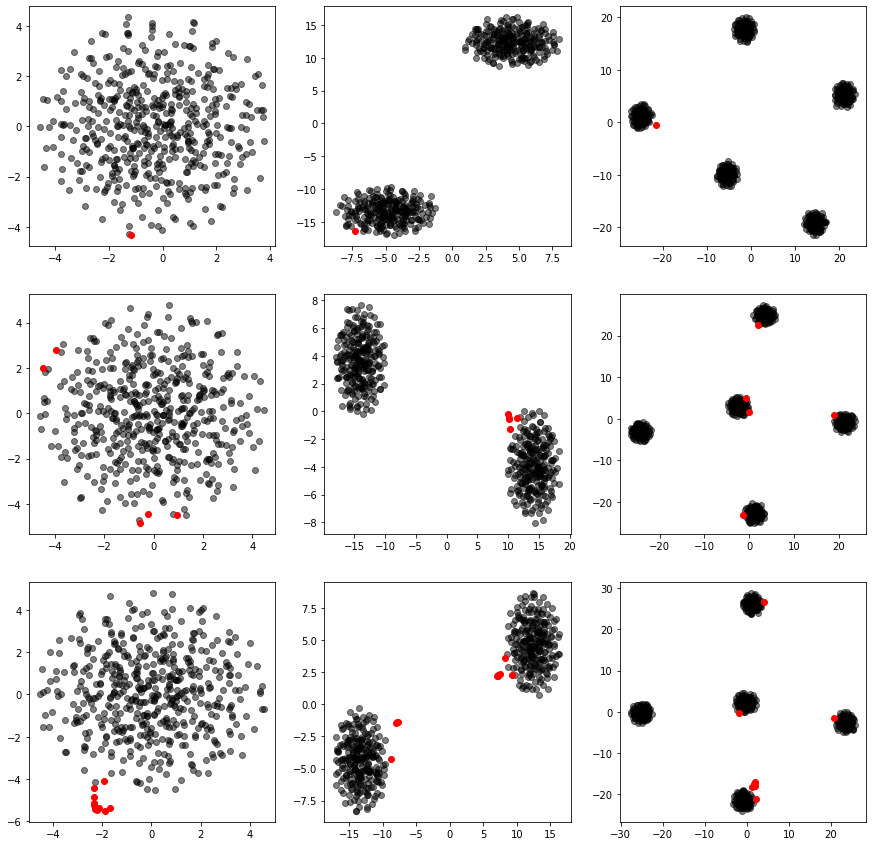

In [ ]:
fig, axs=plt.subplots(5,3, figsize=(15,15))

for i in range(len(num_outliers)):
    for j in range(len(num_clusters)):
        m = num_outliers[i]
        axs[i,j].scatter(plots[i][j][:-m,0], plots[i][j][:-m,1], alpha=0.5 , c='black')
        axs[i,j].scatter(plots[i][j][-m:,0], plots[i][j][-m:,1],  c='r')


In [320]:
alphas = np.linspace(0.1, 5, 100)

pca = PCA(n_components=2)
tsne = TSNE(n_components=2, random_state=42, method='exact', perplexity=30)


pca_alphas = []
tsne_alphas = []
for a in tqdm(alphas):
    X = create_cluster_outlier_config(alpha=a, n=100, k=1, d=20, num_outliers=1, std=0.6)

    X_pca = pca.fit_transform(X)
    X_tsne = tsne.fit_transform(X)
    pca_alphas.append( alpha_quick(X_pca ) )
    tsne_alphas.append( alpha_quick(X_tsne) )


100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


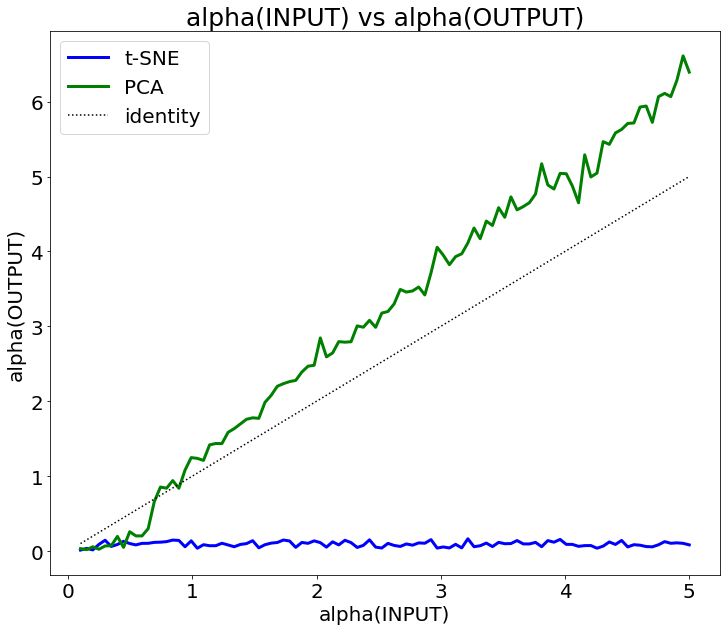

In [321]:
fig, ax = plt.subplots(figsize=(12,10))


ax.plot(alphas, tsne_alphas, color='blue',linewidth = 3,  label='t-SNE')
ax.plot(alphas, pca_alphas, color='green', linewidth = 3, label='PCA')
ax.plot(alphas, alphas,  linestyle=':', color='black', label='identity')

ax.tick_params(axis='both', which='major', labelsize=20)  # make ticks bigger
ax.set_xlabel("alpha(INPUT)", fontsize=20)
ax.set_ylabel("alpha(OUTPUT)", fontsize=20)
ax.set_title("alpha(INPUT) vs alpha(OUTPUT)",fontsize=25)
ax.legend(prop={'size': 20})

plt.savefig('visuals/outlier_new/alpha_IN_OUT.png')

In [ ]:
alphas = np.linspace(0.1, 50, 50)

tsne = TSNE(n_components=2, random_state=42, method='exact', perplexity=30)


tsne_alphas_ = []
for a in tqdm(alphas):
    X = create_cluster_outlier_config(alpha=a, n=100, k=1, d=20, num_outliers=1, std=0.6)
    X_tsne = tsne.fit_transform(X)
    tsne_alphas_.append( alpha_quick(X_tsne) )

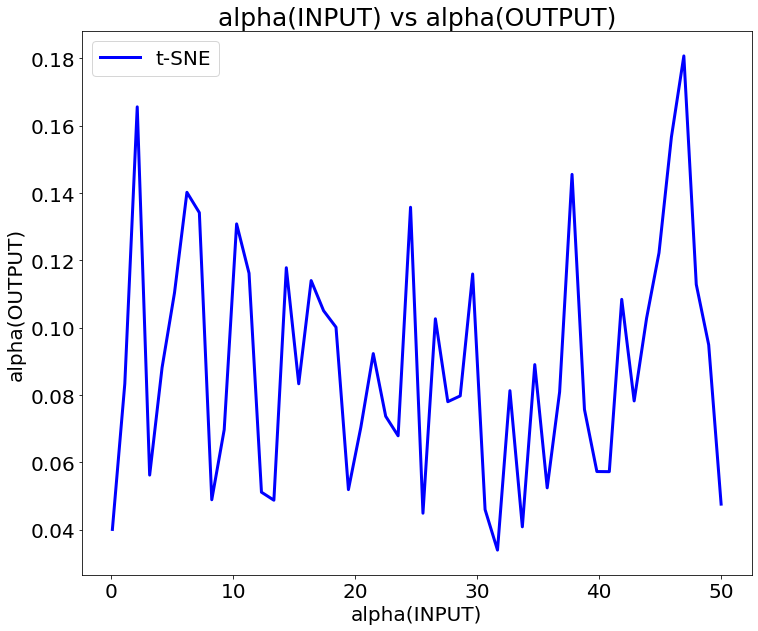

In [68]:
fig, ax = plt.subplots(figsize=(12,10))

ax.plot(alphas, tsne_alphas_, color='blue', linewidth = 3, label='t-SNE')

ax.tick_params(axis='both', which='major', labelsize=20)  # make ticks bigger
ax.set_xlabel("alpha(INPUT)", fontsize=20)
ax.set_ylabel("alpha(OUTPUT)", fontsize=20)
ax.set_title("alpha(INPUT) vs alpha(OUTPUT)",fontsize=25)
ax.legend(prop={'size': 20})

plt.savefig('visuals/outlier_new/alpha_IN_OUT_justTSNE.png')

In [333]:
X = create_cluster_outlier_config(alpha=1, n=500, k=1, d=20, num_outliers=1, std=0.6)

X_pca = pca.fit_transform(X)
X_tsne = tsne.fit_transform(X)

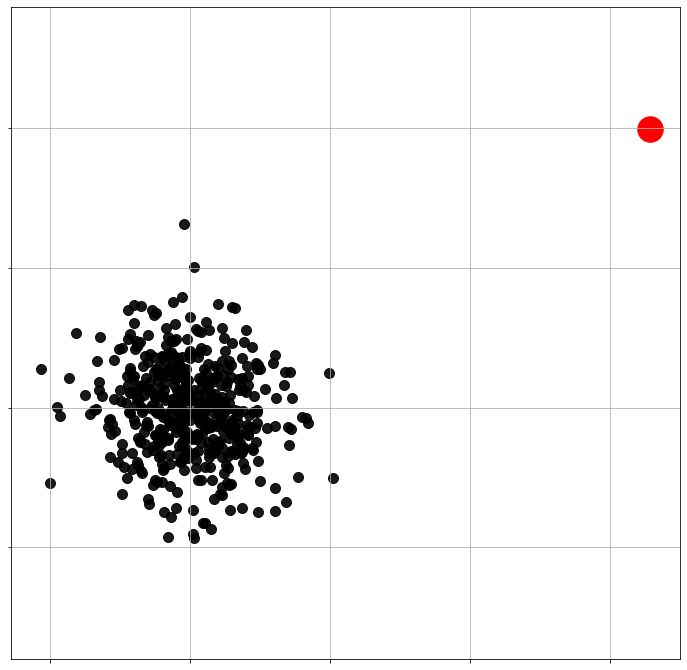

In [334]:
fig, ax = plt.subplots(figsize=(12,12))
ax.grid('on')
ax.axis('equal')
ax.set_xticklabels([])
ax.set_yticklabels([])


plt.scatter(X_pca[:-1, 0], X_pca[:-1, 1], s=100, alpha=0.9, c='black')
plt.scatter(X_pca[-1, 0], X_pca[-1, 1], s=650, alpha=1, c='red')
plt.savefig('visuals/outlier_new/PCA_1outlier.png')

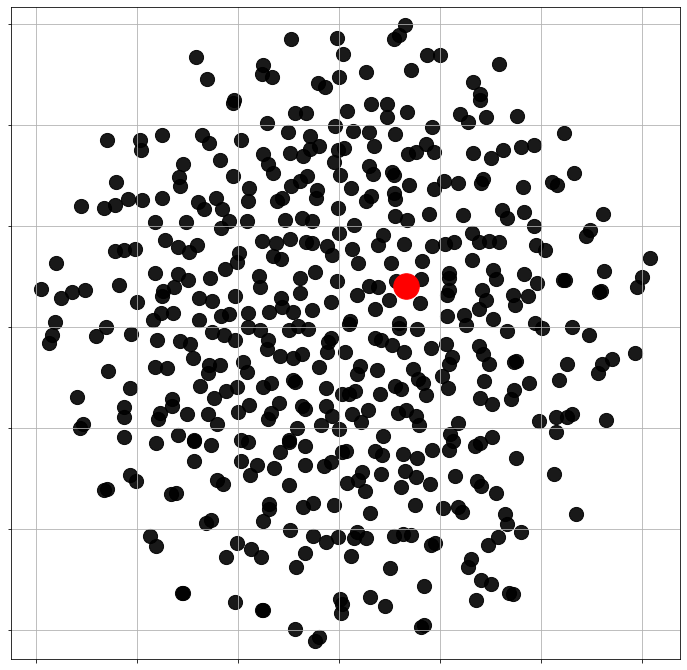

In [335]:
fig, ax = plt.subplots(figsize=(12,12))
ax.grid('on')
ax.axis('equal')
ax.set_xticklabels([])
ax.set_yticklabels([])


plt.scatter(X_tsne[:-1, 0], X_tsne[:-1, 1], s=200, alpha=0.9, c='black')
plt.scatter(X_pca[-1, 0], X_pca[-1, 1], s=650, alpha=1, c='red', marker='o')
plt.savefig('visuals/outlier_new/TSNE_1outlier.png')

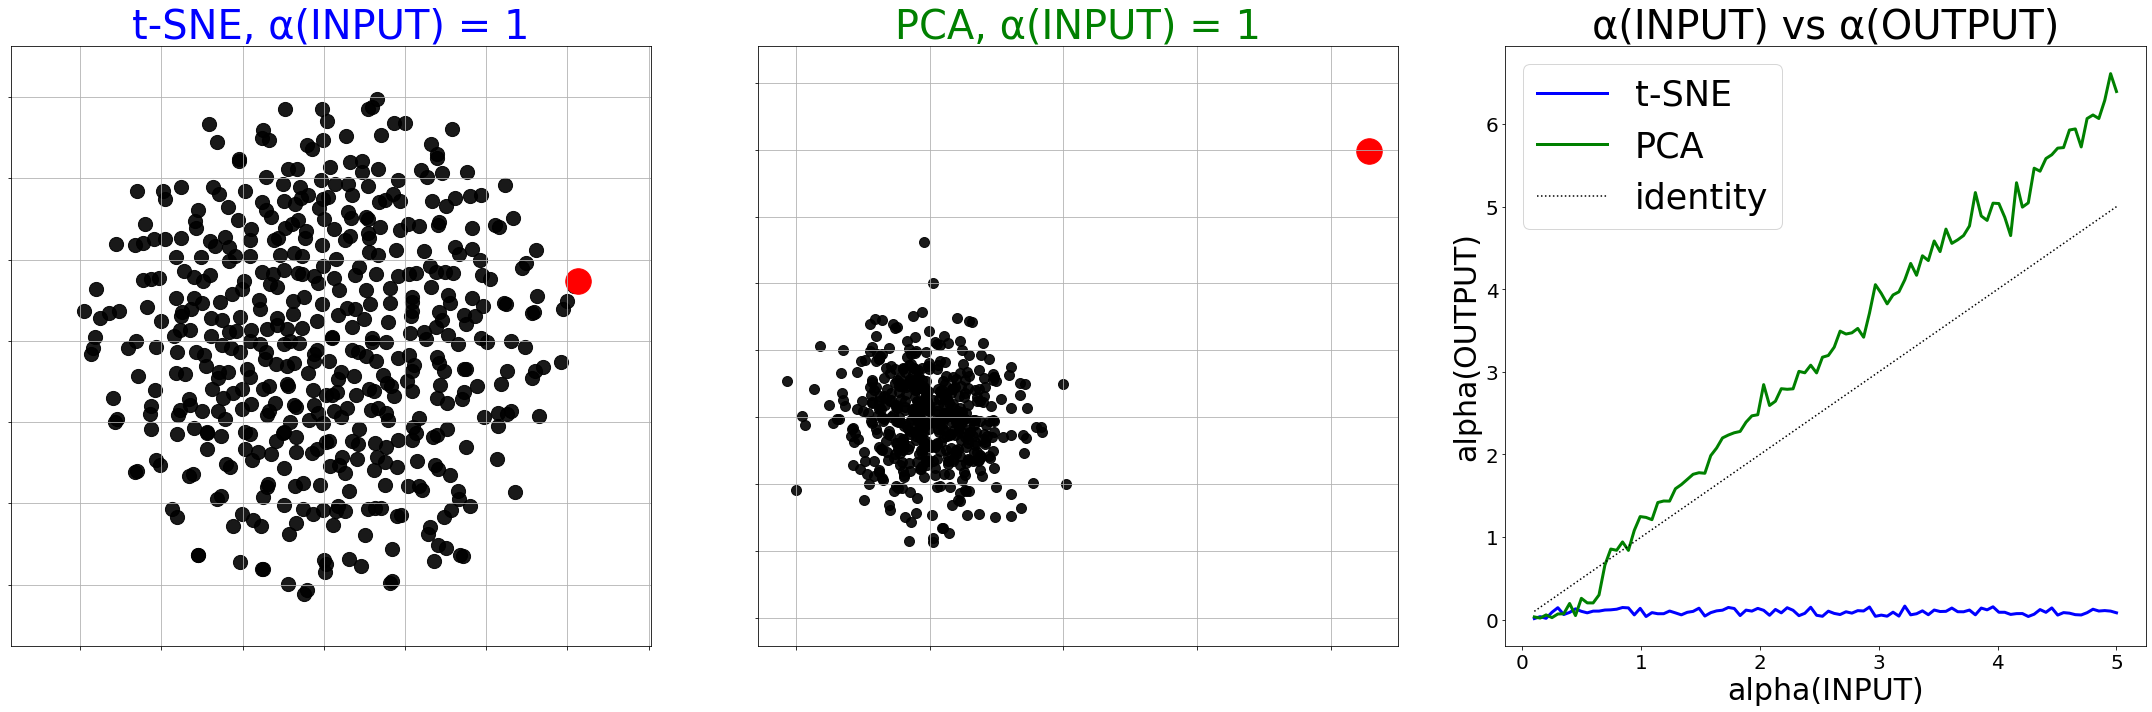

In [337]:
fig, axs = plt.subplots(1,3, figsize=(30,10))
import matplotlib.gridspec as gridspec

#gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 0.3, 1])  
#ax1 = fig.add_subplot(gs[0])

for i in range(2):
    axs[i].grid('on')
    axs[i].axis('equal')
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])

axs[0].set_title('t-SNE, α(INPUT) = 1', fontsize=40, color='blue')
axs[0].scatter(X_tsne[:-1, 0], X_tsne[:-1, 1], s=200, alpha=0.9, c='black')
axs[0].scatter(X_tsne[-1, 0], X_tsne[-1, 1], s=650, alpha=1, c='red', marker='o')

axs[1].set_title('PCA, α(INPUT) = 1', fontsize=40, color='green')
axs[1].scatter(X_pca[:-1, 0], X_pca[:-1, 1], s=100, alpha=0.9, c='black')
axs[1].scatter(X_pca[-1, 0], X_pca[-1, 1], s=650, alpha=1, c='red')

axs[2].plot(alphas, tsne_alphas, color='blue',linewidth = 3,  label='t-SNE')
axs[2].plot(alphas, pca_alphas, color='green', linewidth = 3, label='PCA')
axs[2].plot(alphas, alphas,  linestyle=':', color='black', label='identity')
axs[2].tick_params(axis='both', which='major', labelsize=20)  # make ticks bigger
axs[2].set_xlabel("alpha(INPUT)", fontsize=30)
axs[2].set_ylabel("alpha(OUTPUT)", fontsize=30)
axs[2].set_title("α(INPUT) vs α(OUTPUT)",fontsize=40)
axs[2].legend(prop={'size': 35})

# get position of the 3rd subplot
pos = axs[2].get_position()
# shift it to the right (x0, y0, width, height)
axs[2].set_position([pos.x0 - 0.02, pos.y0, pos.width, pos.height])


plt.tight_layout()
plt.savefig('visuals/outlier_new/alphaINvsOUTwPCA_color.png',  bbox_inches='tight')


In [113]:
m = 3

X = create_cluster_outlier_config(alpha=1, n=200, k=3, d=20, num_outliers=m, std=0.6)


X_pca = pca.fit_transform(X)
X_tsne = tsne.fit_transform(X)

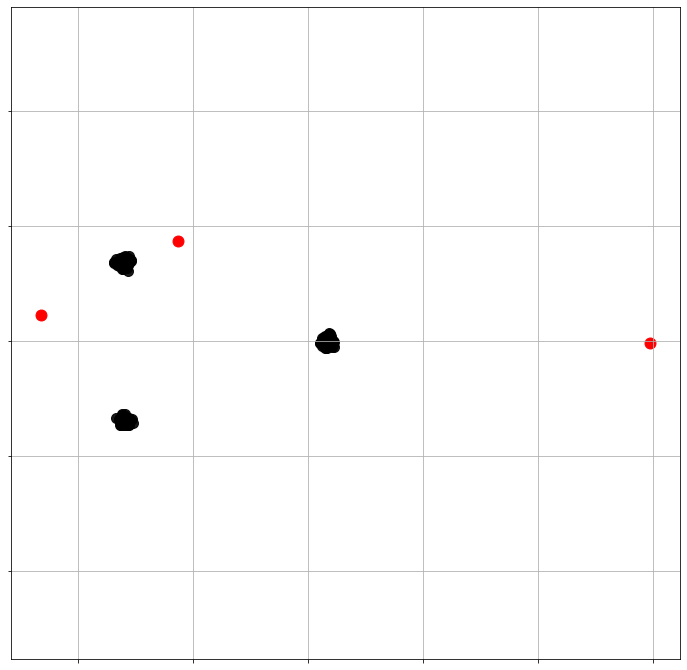

In [114]:
fig, ax = plt.subplots(figsize=(12,12))
ax.grid('on')
ax.axis('equal')
ax.set_xticklabels([])
ax.set_yticklabels([])


plt.scatter(X_pca[:-m, 0], X_pca[:-m, 1], s=100, alpha=0.9, c='black')
plt.scatter(X_pca[-m:, 0], X_pca[-m:, 1], s=120, alpha=1, c='red')
plt.savefig(f'visuals/outlier_new/PCA_{m}outlier.png')

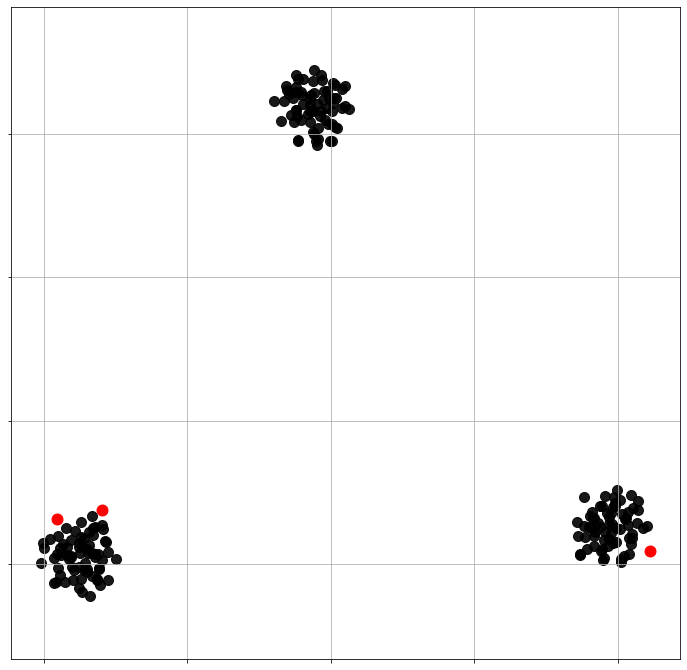

In [115]:
fig, ax = plt.subplots(figsize=(12,12))
ax.grid('on')
ax.axis('equal')
ax.set_xticklabels([])
ax.set_yticklabels([])


plt.scatter(X_tsne[:-m, 0], X_tsne[:-m, 1], s=100, alpha=0.9, c='black')
plt.scatter(X_tsne[-m:, 0], X_tsne[-m:, 1], s=120, alpha=1, c='red')
plt.savefig(f'visuals/outlier_new/TSNE_{m}outlier.png')

In [190]:
def TwoGuassians(NumPointsInCluster=100 ,distance=2, dim=100, power=-3/4, c=1.0):
    u = np.zeros(dim)
    u[0] = distance
    
    X = np.zeros((2*NumPointsInCluster, dim))
    X[0:NumPointsInCluster] = np.random.multivariate_normal(np.zeros(dim),  np.multiply(c,np.power(dim,power)*np.identity(dim)), size = NumPointsInCluster)
    X[NumPointsInCluster:2*NumPointsInCluster] = np.random.multivariate_normal(u,  np.multiply(c,np.power(dim,power)*np.identity(dim)), size = NumPointsInCluster)
    
    return X

In [191]:
X = TwoGuassians(NumPointsInCluster=200, distance=1, dim=2000)
X1 = np.concatenate((X, np.array( [  np.mean(X, axis=0)  ])), axis=0)

In [ ]:
X2 = X.copy()
m = 100
for i in range(m):
    outlier = np.random.normal(size=(1,X2.shape[1]))
    X2 = np.concatenate( (X2,  outlier ) , axis=0)

In [193]:
X_tsne0 = tsne.fit_transform(X)
X_tsne1 = tsne.fit_transform(X1)
X_tsne2 = tsne.fit_transform(X2)

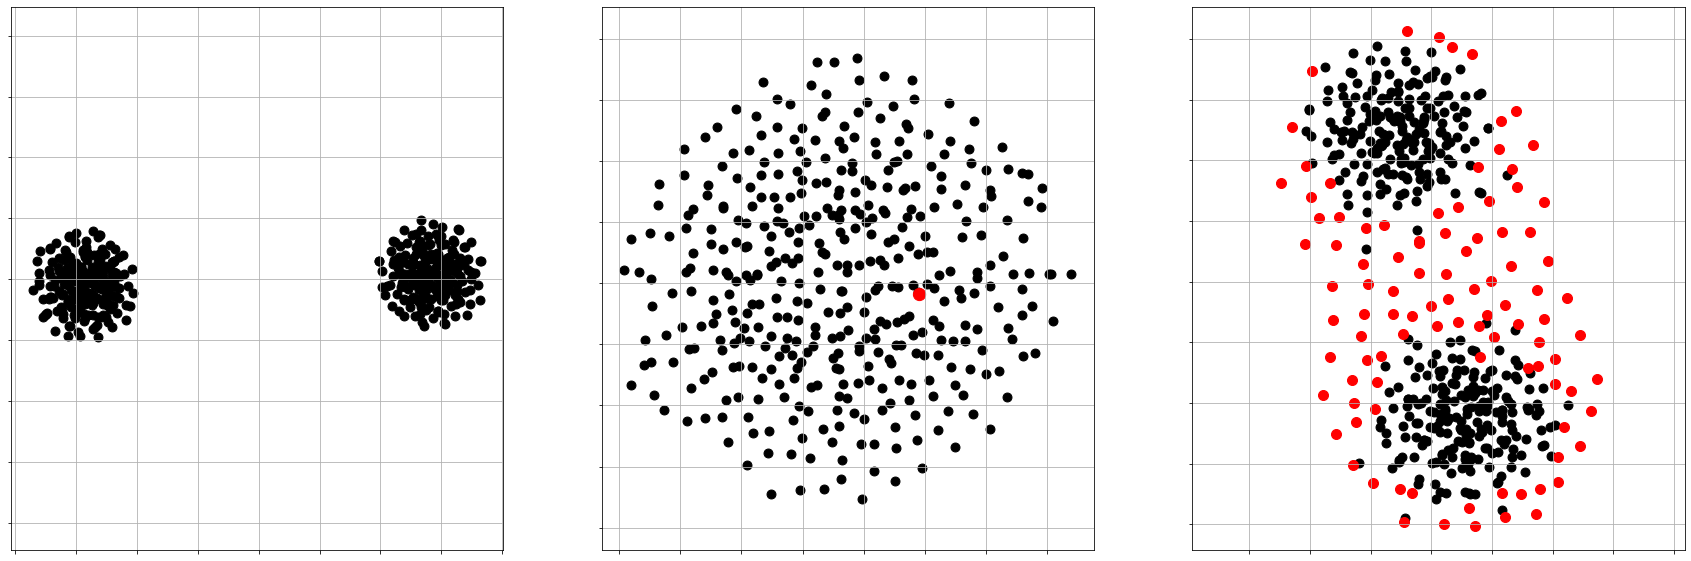

In [194]:
fig, axs = plt.subplots(1,3, figsize=(30,10))
n = len(X)

for i in range(3):
    axs[i].grid('on')
    axs[i].axis('equal')
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])

axs[0].scatter(X_tsne0[:,0],X_tsne0[:,1],  s=80,color='black')
axs[1].scatter(X_tsne1[:-1,0],X_tsne1[:-1,1], s=80, color='black')
axs[1].scatter(X_tsne1[-1,0],X_tsne1[-1,1], s=150, color='red')
axs[2].scatter(X_tsne2[:-m,0],X_tsne2[:-m,1], s=80, color='black')
axs[2].scatter(X_tsne2[-m:,0],X_tsne2[-m:,1], s=100, color='red')

plt.savefig('visuals/outlier_new/internal_vs_external_outlier.png')

In [195]:
X_pca0 = pca.fit_transform(X)
X_pca1 = pca.fit_transform(X1)

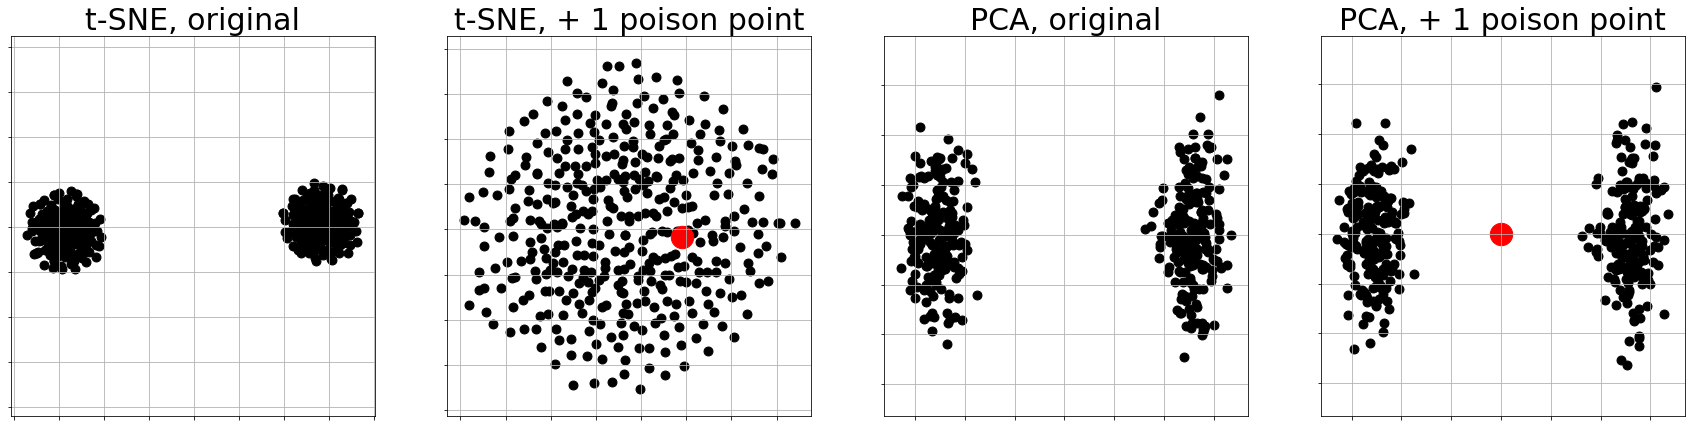

In [365]:
fig, axs = plt.subplots(1,4, figsize=(30,7))
n = len(X)

for i in range(4):
    axs[i].grid('on')
    axs[i].axis('equal')
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])

axs[0].scatter(X_tsne0[:,0],X_tsne0[:,1],  s=80,color='black')
axs[0].set_title('t-SNE, original', fontsize=30)

axs[1].scatter(X_tsne1[:-1,0],X_tsne1[:-1,1], s=80, color='black')
axs[1].scatter(X_tsne1[-1,0],X_tsne1[-1,1],  s=500, color='red')
axs[1].set_title('t-SNE, + 1 poison point', fontsize=30)


axs[2].scatter(X_pca0[:,0],X_pca0[:,1],  s=80,color='black')
axs[2].set_title('PCA, original', fontsize=30)

axs[3].scatter(X_pca1[:-1,0],X_pca1[:-1,1], s=80, color='black')
axs[3].scatter(X_pca1[-1,0],X_pca1[-1,1],  s=500, color='red')
axs[3].set_title('PCA, + 1 poison point', fontsize=30)


plt.savefig('visuals/outlier_new/one_pt_perturb.png', bbox_inches='tight' )

In [351]:
X = TwoGuassians(NumPointsInCluster=200, distance=1, dim=2000)


injected_points = [1, 10, 100, 500, 1000]
TSNE_plots = []
PCA_plots = []



for i in tqdm(injected_points):
    X__ = np.concatenate( (X,  np.mean(X,axis=0) + 0.2 * np.random.normal(size=( i ,X.shape[1]))  ) , axis=0)
    TSNE_plots.append( tsne.fit_transform(X__)  )
    PCA_plots.append( pca.fit_transform(X__)  )


100%|██████████| 5/5 [00:52<00:00, 10.60s/it]


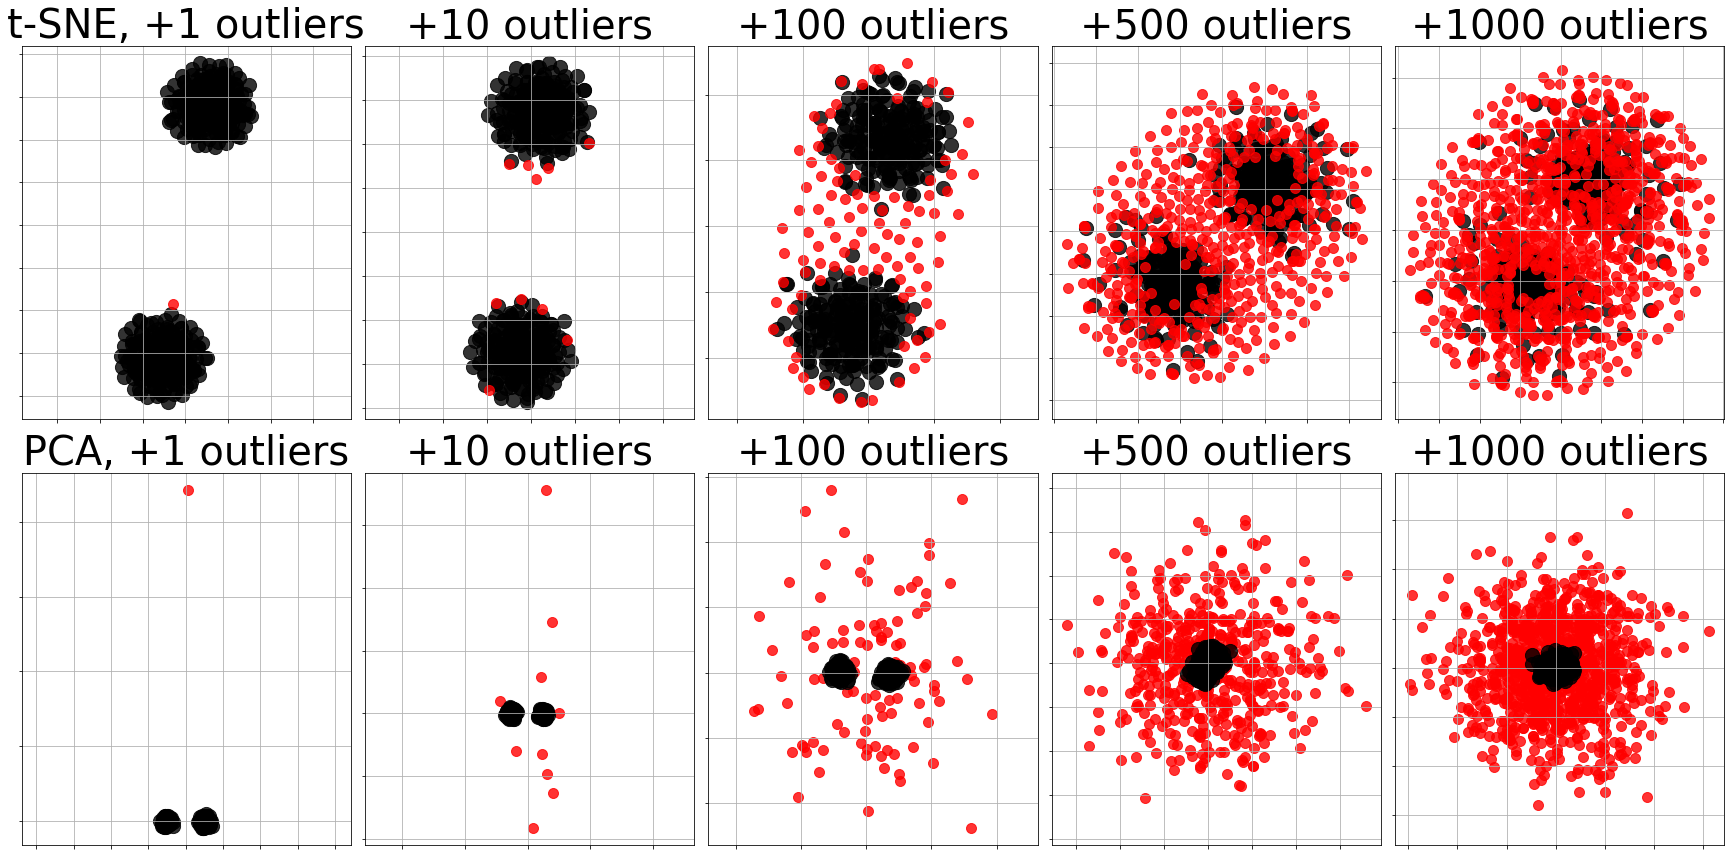

In [353]:
fig, axs = plt.subplots(2,5, figsize=(24,12))

#axs[0,0].set_ylabel('t-SNE', fontsize=50, rotation='horizontal')
#axs[1,0].set_ylabel('PCA', fontsize=50, rotation='horizontal')

for i in range(5):
    axs[0,i].grid('on')
    axs[0,i].axis('equal')
    axs[0,i].set_xticklabels([])
    axs[0,i].set_yticklabels([])
    axs[1,i].grid('on')
    axs[1,i].axis('equal')
    axs[1,i].set_xticklabels([])
    axs[1,i].set_yticklabels([])

    m = injected_points[i]
    if i==0:
        axs[0, i].set_title(f't-SNE, +{m} outliers', fontsize=40)
        axs[1, i].set_title(f'PCA, +{m} outliers', fontsize=40)
    else:
        axs[0, i].set_title(f'+{m} outliers', fontsize=40)
        axs[1, i].set_title(f'+{m} outliers', fontsize=40)
    axs[0,i].scatter(  TSNE_plots[i][:-m,0] ,  TSNE_plots[i][:-m,1], s=200,color='black', alpha=0.8)
    axs[0,i].scatter(  TSNE_plots[i][-m:,0] ,  TSNE_plots[i][-m:,1], s=100, color='red', alpha=0.8)

    axs[1,i].scatter(  PCA_plots[i][-m:,0] ,  PCA_plots[i][-m:,1], s=100, color='red', alpha=0.8)
    axs[1,i].scatter(  PCA_plots[i][:-m,0] ,  PCA_plots[i][:-m,1], s=200, color='black', alpha=0.8)
plt.tight_layout()
plt.savefig('visuals/outlier_new/outlier_infusion.png',  bbox_inches='tight')

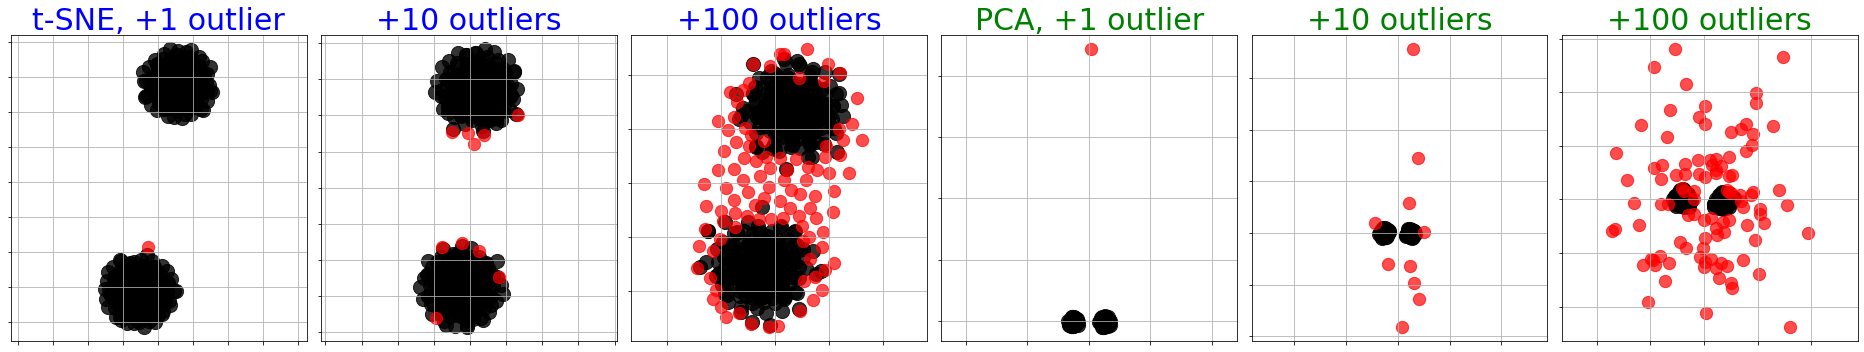

In [360]:
fig, axs = plt.subplots(1,6, figsize=(26,5))

#axs[0,0].set_ylabel('t-SNE', fontsize=50, rotation='horizontal')
#axs[1,0].set_ylabel('PCA', fontsize=50, rotation='horizontal')

for i in range(6):
    axs[i].grid('on')
    axs[i].axis('equal')
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])



for i in range(3):
    m = injected_points[i]
    if i==0:
        axs[i].set_title(f't-SNE, +{m} outlier', fontsize=30, color='blue')
        axs[3+i].set_title(f'PCA, +{m} outlier', fontsize=30, color='green')
    else:
        axs[i].set_title(f'+{m} outliers', fontsize=30, color='blue')
        axs[3+i].set_title(f'+{m} outliers', fontsize=30, color='green')
    axs[i].scatter(  TSNE_plots[i][:-m,0] ,  TSNE_plots[i][:-m,1], s=200,color='black', alpha=0.8)
    axs[i].scatter(  TSNE_plots[i][-m:,0] ,  TSNE_plots[i][-m:,1], s=150, color='red', alpha=0.7)

    axs[3+i].scatter(  PCA_plots[i][:-m,0] ,  PCA_plots[i][:-m,1], s=200, color='black', alpha=0.8)
    axs[3+i].scatter(  PCA_plots[i][-m:,0] ,  PCA_plots[i][-m:,1], s=150, color='red', alpha=0.7)
plt.tight_layout()
plt.savefig('visuals/outlier_new/outlier_infusion.png',  bbox_inches='tight')

In [568]:
# y is outlier labelling:
#   y = +1 if non-outlier, -1 if outlier
# 2d visualizations
# recording their alphas
def make_visualizations(X, y, calculate_alpha = False):

    methods = {'PCA': PCA(n_components=2)  , 
               'TSNE': TSNE(n_components=2, random_state=42, method='exact', perplexity=30)}
               #'MDS': MDS(n_components=2) , 
               #'UMAP': umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42) }

    outputs = {}
    outlier_ixs = np.where(y==-1)[0]
    inlier_ixs = np.where(y==1)[0]

    for m in methods:

        X_method = methods[m].fit_transform(X)

        if calculate_alpha:
            alphas = []

            for o in outlier_ixs:
                X_m = X_method.copy()
                X_m[outlier_ixs] = np.mean(X_m, axis=0)
                X_m[o] = X_method[o]
                alphas.append( alpha_(X_m, o)  )
                del X_m

            outputs[m] = {'embedding': X_method, 'alphas':alphas}
        else:
            outputs[m] = {'embedding': X_method}

    return outputs


n  = 200
n_outliers = 20
X = create_cluster_outlier_config(alpha=2, n=n, k=1, d=2, num_outliers=n_outliers, std=0.6)
y = np.array(n*[1] + n_outliers*[-1])


outputs = make_visualizations(X, y)


fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].scatter(outputs['PCA']['embedding'][:,0],outputs['PCA']['embedding'][:,1], c=y)
axs[1].scatter(outputs['TSNE']['embedding'][:,0],outputs['TSNE']['embedding'][:,1], c=y)



: 

: 

(array([ 1.,  0., 36.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 29.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 33.]),
 array([2.10318538, 2.10453556, 2.10588574, 2.10723592, 2.1085861 ,
        2.10993629, 2.11128647, 2.11263665, 2.11398683, 2.11533701,
        2.11668719, 2.11803738, 2.11938756, 2.12073774, 2.12208792,
        2.1234381 , 2.12478829, 2.12613847, 2.12748865, 2.12883883,
        2.13018901, 2.13153919, 2.13288938, 2.13423956, 2.13558974,
        2.13693992, 2.1382901 , 2.13964028, 2.14099047, 2.14234065,
        2.14369083, 2.1450

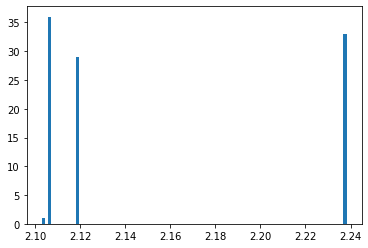

In [557]:
alphas = []

for i in range(1,100):
    X_test  =  np.array([[-10*i,0, 1]]).T
    X_test_tsne = TSNE(n_components=1, random_state=42, method='exact', perplexity=1.9).fit_transform(X_test)
    alphas.append( max(pdist(X_test_tsne))/min(pdist(X_test_tsne)) )

plt.hist(alphas, bins=100)







(210, 100)


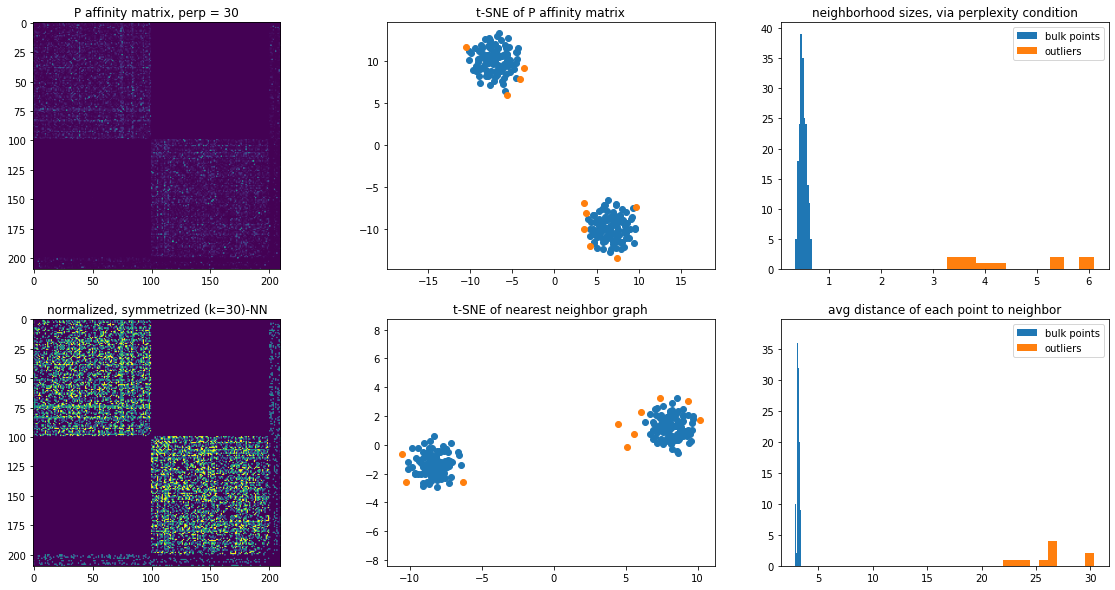

In [ ]:
from functions import x2p
import numpy as np
from functions import *
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS, TSNE
from sklearn.datasets import load_digits
from sklearn import random_projection
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
from tqdm import tqdm
import umap
from sklearn.neighbors import kneighbors_graph


far = 2
dim = 100
num_outliers = 10
n = 200
n_neighbors = 40

X = outlier_config(n, far, dim, num_outliers)
partition = [ list(range(n)), list(range(n, n + num_outliers))  ]


P, sigma = x2p(X, perplexity=n_neighbors)
#Y, loss_curve, radius_curve, Z_curve = tsne_(P)
Y = TSNE(n_components=2, random_state=42, method='exact', perplexity=30).fit_transform(X)


A = kneighbors_graph(X, n_neighbors=30, mode='connectivity', include_self=False)
A = A.toarray()
A /= np.sum(A, axis=1)
A += A.T
A /= np.sum(A)
Y_A, loss_curve, radius_curve, Z_curve = tsne_(A)

nbhd_sizes_A = np.sum(kneighbors_graph(X, n_neighbors=n_neighbors, metric='euclidean',mode='distance', include_self=False).toarray(), axis=1) / 30

fig, axs = plt.subplots(2,3, figsize=(20,10))

axs[0,0].imshow(P)
axs[0,0].set_title('P affinity matrix, perp = 30')
axs[0,1].scatter(Y[partition[0],0],Y[partition[0],1], label='sigma of bulk')
axs[0,1].scatter(Y[partition[1],0],Y[partition[1],1], label='sigma of outliers')
axs[0,1].axis('equal')
axs[0,1].set_title('t-SNE of P affinity matrix')
axs[0,2].hist(sigma[partition[0]]**2, label='bulk points')
axs[0,2].hist(sigma[partition[1]]**2, label='outliers')
axs[0,2].legend()
axs[0,2].set_title('neighborhood sizes, via perplexity condition')


axs[1,0].imshow(A)
axs[1,0].set_title('normalized, symmetrized (k=30)-NN')
axs[1,1].scatter(Y_A[partition[0],0],Y_A[partition[0],1], label='sigma of bulk')
axs[1,1].scatter(Y_A[partition[1],0],Y_A[partition[1],1], label='sigma of outliers')
axs[1,1].axis('equal')
axs[1,1].set_title('t-SNE of nearest neighbor graph')
axs[1,2].hist(nbhd_sizes_A[partition[0]], label='bulk points')
axs[1,2].hist(nbhd_sizes_A[partition[1]], label='outliers')
axs[1,2].legend()
axs[1,2].set_title('avg distance of each point to neighbor')

plt.savefig('visuals/outliers/comparison_with_knn')
#plt.hist()

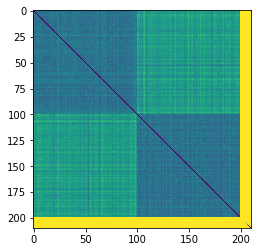

In [ ]:
plt.imshow(cdist(X, X, metric='euclidean'),vmin=1, vmax= 5)

(110, 2)


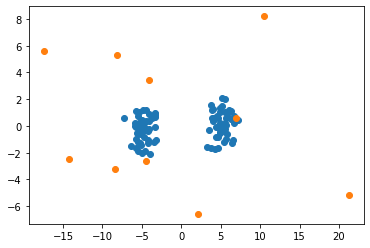

In [ ]:
from sklearn.datasets import make_blobs
def outlier_config(n, far, dim, num_outliers, k=2):

    #X = np.random.multivariate_normal(np.zeros(dim), np.identity(dim), size=n)
    #X,y = two_gaussians_labelled(NumPointsInCluster=int(n/2) ,distance=far, dim=dim)
    X, y = make_blobs(n_samples=n,     # number of points
                  centers=2,         # number of clusters
                  cluster_std=1.0,   # standard deviation of clusters
                  random_state=42)

    #if k==2 and n % 2 == 0:
    #    X = two_gaussians(NumPointsInCluster=n/2)
    for i in range(num_outliers):
        random_vector = far*np.random.normal(size=dim) + np.mean(X, axis=0)
        unit_vector = (far)*random_vector / np.linalg.norm(random_vector)
        X = np.concatenate( (X, np.array([random_vector])), axis=0)
    print(X.shape)
    return X

far = 50
dim= 2
far = 10
n=100
num_outliers=10
partition = [ list(range(n)), list(range(n, n + num_outliers))  ]
X = outlier_config(n, far, dim, num_outliers, k=2)

pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[partition[0],0], X_pca[partition[0],1])
plt.scatter(X_pca[partition[1],0], X_pca[partition[1],1])

(21, 200)


/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


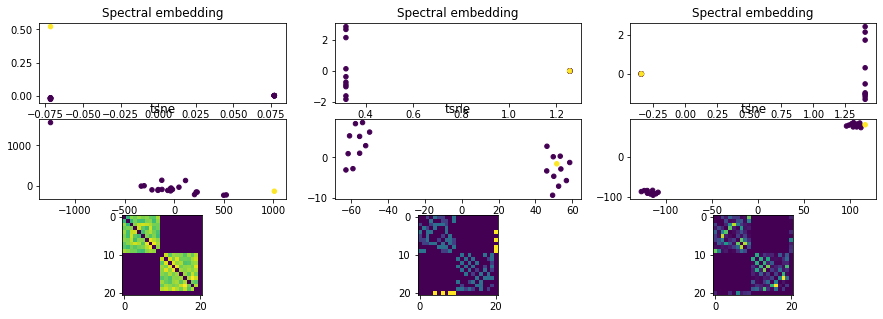

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph
from sklearn.manifold import SpectralEmbedding
from sklearn.manifold import TSNE

far = 50
dim = 200
num_outliers = 1
n = 20

X = outlier_config(n, far, dim, num_outliers)
y_true = [ 0] *n + [1]*num_outliers

k = int(n/4)

P0 = distance_matrix(X, X)
P0 = np.exp(-distance_matrix(X, X)) - np.eye(len(X))
P0 / np.sum(P0)
embed_knn = SpectralEmbedding(n_components=2, affinity='rbf', random_state=42)
Y0 = embed_knn.fit_transform(X)
Y0_tsne, _, _, _ = tsne_(P0)



A = kneighbors_graph(X, k, mode='distance', include_self=True)
A = A.toarray()
#print(np.sum(A, axis=1))
#A /= np.sum(A, axis=1)
#print(np.sum(A, axis=1))
A += A.T
A /= np.sum(A)
P1 = A
embed_knn = SpectralEmbedding(n_components=2, affinity='precomputed', random_state=42)
Y1 = embed_knn.fit_transform(P1)
Y1_tsne, _, _, _ = tsne_(P1)


P2, sigma = x2p(X, perplexity=k)
embed_knn = SpectralEmbedding(n_components=2, affinity='precomputed', random_state=42)
Y2 = embed_knn.fit_transform(P2)
Y2_tsne, _, _, _ = tsne_(P2)


# --- Step 4: Visualize ---
fig, axs = plt.subplots(3, 3, figsize=(15, 5))

# Original data
axs[0,0].scatter(Y0[:, 0], Y0[:, 1], c=y_true,  s=20)
axs[1,0].scatter(Y0_tsne[:, 0], Y0_tsne[:, 1], c=y_true,  s=20)
axs[2,0].imshow(P0)
axs[0,0].set_title("Spectral embedding")
axs[1,0].set_title("tsne")


# Spectral embedding from k-NN graph
axs[0,1].scatter(Y1[:, 0], Y1[:, 1], c=y_true,  s=20)
axs[1,1].scatter(Y1_tsne[:, 0], Y1_tsne[:, 1], c=y_true,  s=20)
axs[2,1].imshow(P1)
axs[0,1].set_title(f"Spectral embedding")
axs[1,1].set_title(f"tsne")

# Spectral embedding from radius graph
axs[0,2].scatter(Y2[:, 0], Y2[:, 1], c=y_true,  s=20)
axs[1,2].scatter(Y2_tsne[:, 0], Y2_tsne[:, 1], c=y_true,  s=20)
axs[2,2].imshow(P2)
axs[0,2].set_title(f"Spectral embedding ")
axs[0,2].set_title(f"Spectral embedding")
axs[1,2].set_title(f"tsne")

plt.show()


In [ ]:
R = 100
n = 200
X = [[-R] + [0]*n + [1]*n]
X = np.array(X).T

# Parameters for Gaussian noise
mean = 0.0
std_dev = 0.1  # standard deviation

# Add noise
noise = np.random.normal(mean, std_dev, size=X.shape)
X = X + noise

x2p(X, perplexity=20)[0].shape


/Users/noahbergam/Desktop/tsne-mode-collapse/functions.py:36: RuntimeWarning: divide by zero encountered in log
  H = np.log(sumP) + beta * np.sum(D * P) / sumP
/Users/noahbergam/Desktop/tsne-mode-collapse/functions.py:36: RuntimeWarning: invalid value encountered in divide
  H = np.log(sumP) + beta * np.sum(D * P) / sumP
/Users/noahbergam/Desktop/tsne-mode-collapse/functions.py:37: RuntimeWarning: invalid value encountered in divide
  P = P / sumP


(401, 401)

In [ ]:
def x2p_conditional(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    #print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    P = np.array(P, dtype=np.float128)
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        #if i % 500 == 0:
            #print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    #print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    #print("MIN value of sigma: %f" % np.min(np.sqrt(1 / beta)))
    #print('')
    sig = np.sqrt(1 / beta)

    for i in range(n):
        P[i,i] = 0

    #P = P + np.transpose(P)
    #P = P / np.sum(P)
    P = np.array(P, dtype=np.float64)
    return P

(220, 40)


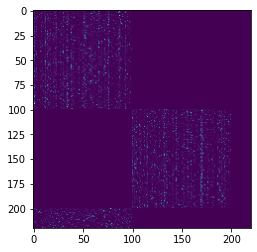

In [ ]:
far = 200
dim = 40
num_outliers = 20
n = 200
X = outlier_config(n, far, dim, num_outliers)
P_conditional =  x2p_conditional(X)
plt.imshow(P_conditional)

In [ ]:
percluster = 20
far = 1
dim = 10
num_outliers = 1


X,y = two_gaussians_labelled(NumPointsInCluster=percluster ,distance=far, dim=dim)

for i in range(num_outliers):
    random_vector = np.random.normal(size=dim)
    unit_vector = diam(X)*(far)*random_vector / np.linalg.norm(random_vector)

    print(X.shape)
    print(random_vector.shape)
    X = np.concatenate((X, np.array([random_vector])), axis=0)

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = reducer.fit_transform(X)


(40, 10)
(10,)


/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [556]:
methods = ['TSNE', 'PCA', 'MDS']
alpha_in = np.linspace(0,5,50)
alphas_out = []


percluster=50


for i in range(len(methods)):

    alpha_out = []

    for f in alpha_in:

        ab_orig, ab_output = make_outlier_config2(30, percluster, far=f, method = methods[i])
        alpha_out.append(ab_output[0])
    
    alphas_out.append(alpha_out)


    #plt.xlim(0,2)
    #plt.ylim(0,2)


    #axs[i].scatter(alpha_in,alpha_out)
    plt.plot(alpha_in,alpha_out, label=methods[i])
    #axs[i].set_title(methods[i]+': t-SNE effect on alpha')
    #axs[i].set_xlabel('alpha of input')
    #axs[i].set_ylabel('alpha of t-SNE output')

    #axs[i,1].scatter(beta_in,beta_out)
    #axs[i,1].set_title(methods[i]+': t-SNE effect on beta')
    #axs[i,1].set_xlabel('beta of input')
    #axs[i,1].set_ylabel('beta of t-SNE output')

plt.legend()




NameError: name 'make_outlier_config2' is not defined

In [555]:
fig = plt.figure(figsize=(13, 10))

plt.plot(alpha_in,alphas_out[0], label=methods[0], color='red')
plt.plot(alpha_in,alphas_out[1], label=methods[1], color='blue')
plt.plot(alpha_in,alphas_out[2], label=methods[2], color='green')
plt.plot(alpha_in,alpha_in, linestyle='dotted', color='black',label='control')
plt.legend()
plt.xlabel('alpha(INPUT)')
plt.ylabel('alpha(EMBEDDING)')
plt.title('alpha(INPUT) vs alpha(OUTPUT)')
plt.savefig('visuals/outliers/alpha_in_vs_output.png')

NameError: name 'alpha_in' is not defined

<Figure size 936x720 with 0 Axes>

In [ ]:
### PUTTING IT ALL TOGETHER



/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold

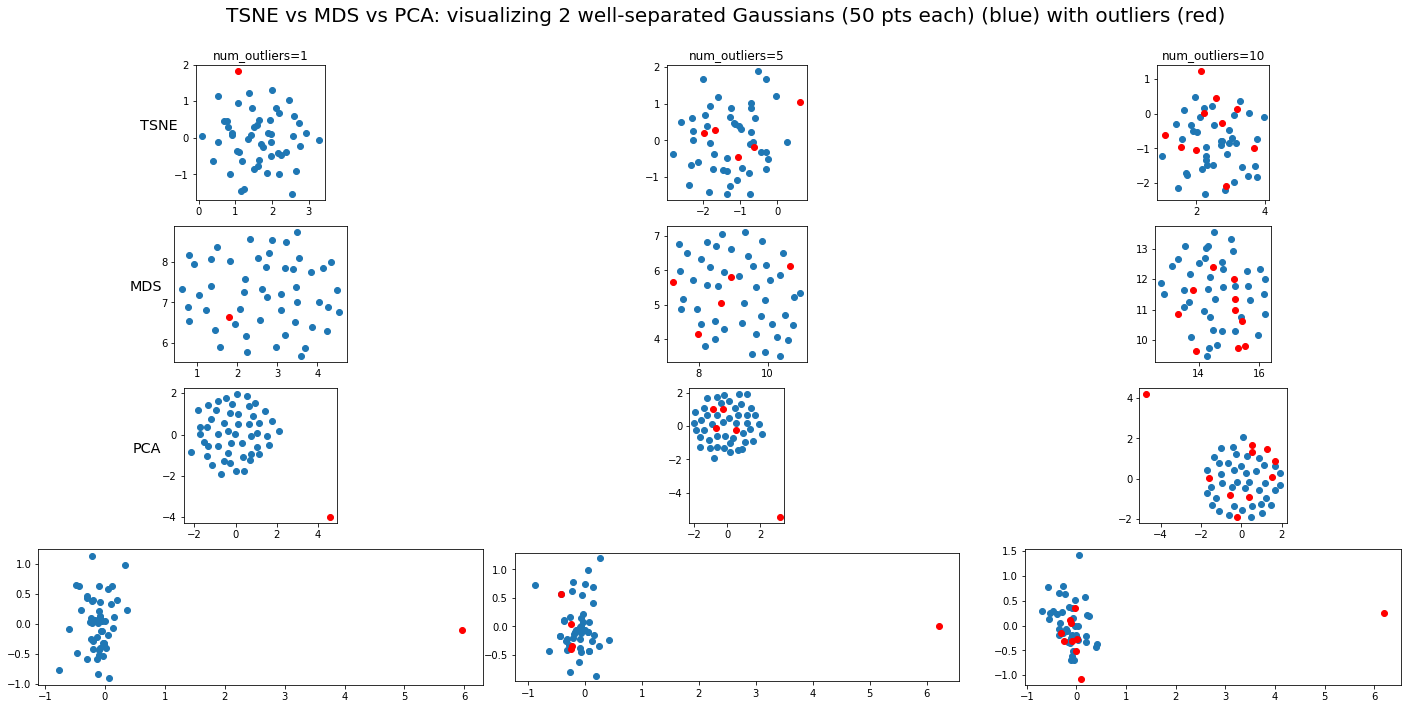

In [ ]:

percluster=50
#num_outliers = 5

X_mds1, X_pca1, X_tsne1, X_umap1, ab1 = make_outlier_vis(50, percluster, num_outliers=1,far=5)
X_mds2, X_pca2, X_tsne2, X_umap2, ab2 = make_outlier_vis(50, percluster, num_outliers=1,far=50)
X_mds3, X_pca3, X_tsne3, X_umap3, ab3 = make_outlier_vis(50, percluster, num_outliers=1,far=500)

fig, axs = plt.subplots(4,3, figsize=(20,10))

num_outliers = [1,5,10]

# TSNE
axs[0,0].scatter(X_tsne1[:-num_outliers[0], 0], X_tsne1[:-num_outliers[0], 1])
axs[0,0].scatter(X_tsne1[-num_outliers[0]:, 0], X_tsne1[-num_outliers[0]:, 1],c='r')
axs[0,0].set_aspect('equal')

axs[0,1].scatter(X_tsne2[:-num_outliers[1], 0], X_tsne2[:-num_outliers[1], 1])
axs[0,1].scatter(X_tsne2[-num_outliers[1]:, 0], X_tsne2[-num_outliers[1]:, 1],c='r')
axs[0,1].set_aspect('equal')

axs[0,2].scatter(X_tsne3[:-num_outliers[2], 0], X_tsne3[:-num_outliers[2], 1])
axs[0,2].scatter(X_tsne3[-num_outliers[2]:, 0], X_tsne3[-num_outliers[2]:, 1],c='r')
axs[0,2].set_aspect('equal')

# UMAP
axs[1,0].scatter(X_umap1[:-num_outliers[0], 0], X_umap1[:-num_outliers[0], 1])
axs[1,0].scatter(X_umap1[-num_outliers[0]:, 0], X_umap1[-num_outliers[0]:, 1],c='r')
axs[1,0].set_aspect('equal')

axs[1,1].scatter(X_umap2[:-num_outliers[1], 0], X_umap2[:-num_outliers[1], 1])
axs[1,1].scatter(X_umap2[-num_outliers[1]:, 0], X_umap2[-num_outliers[1]:, 1],c='r')
axs[1,1].set_aspect('equal')

axs[1,2].scatter(X_umap3[:-num_outliers[2], 0], X_umap3[:-num_outliers[2], 1])
axs[1,2].scatter(X_umap3[-num_outliers[2]:, 0], X_umap3[-num_outliers[2]:, 1],c='r')
axs[1,2].set_aspect('equal')

# MDS
axs[2,0].scatter(X_mds1[:-num_outliers[0], 0], X_mds1[:-num_outliers[0], 1])
axs[2,0].scatter(X_mds1[-num_outliers[0]:, 0], X_mds1[-num_outliers[0]:, 1],c='r')
axs[2,0].set_aspect('equal')

axs[2,1].scatter(X_mds2[:-num_outliers[1], 0], X_mds2[:-num_outliers[1], 1])
axs[2,1].scatter(X_mds2[-num_outliers[1]:, 0], X_mds2[-num_outliers[1]:, 1],c='r')
axs[2,1].set_aspect('equal')

axs[2,2].scatter(X_mds3[:-num_outliers[2], 0], X_mds3[:-num_outliers[2], 1])
axs[2,2].scatter(X_mds3[-num_outliers[2]:, 0], X_mds3[-num_outliers[2]:, 1],c='r')
axs[2,2].set_aspect('equal')


# PCA
axs[3,0].scatter(X_pca1[:-num_outliers[0], 0], X_pca1[:-num_outliers[0], 1])
axs[3,0].scatter(X_pca1[-num_outliers[0]:, 0], X_pca1[-num_outliers[0]:, 1],c='r')
axs[3,0].set_aspect('equal')

axs[3,1].scatter(X_pca2[:-num_outliers[1], 0], X_pca2[:-num_outliers[1], 1])
axs[3,1].scatter(X_pca2[-num_outliers[1]:, 0], X_pca2[-num_outliers[1]:, 1],c='r')
axs[3,1].set_aspect('equal')

axs[3,2].scatter(X_pca3[:-num_outliers[2], 0], X_pca3[:-num_outliers[2], 1])
axs[3,2].scatter(X_pca3[-num_outliers[2]:, 0], X_pca3[-num_outliers[2]:, 1],c='r')
axs[3,2].set_aspect('equal')



cols = ['num_outliers=1', 'num_outliers=5', 'num_outliers=10']
rows = ['TSNE', 'MDS', 'PCA']


for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, labelpad=15,rotation=0, size='x-large')

fig.tight_layout()
fig.suptitle(f'TSNE vs MDS vs PCA: visualizing 2 well-separated Gaussians ({percluster} pts each) (blue) with outliers (red)', fontsize=20)
plt.subplots_adjust(top=0.9)

plt.savefig('visuals/outlier_detection.png')



/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold

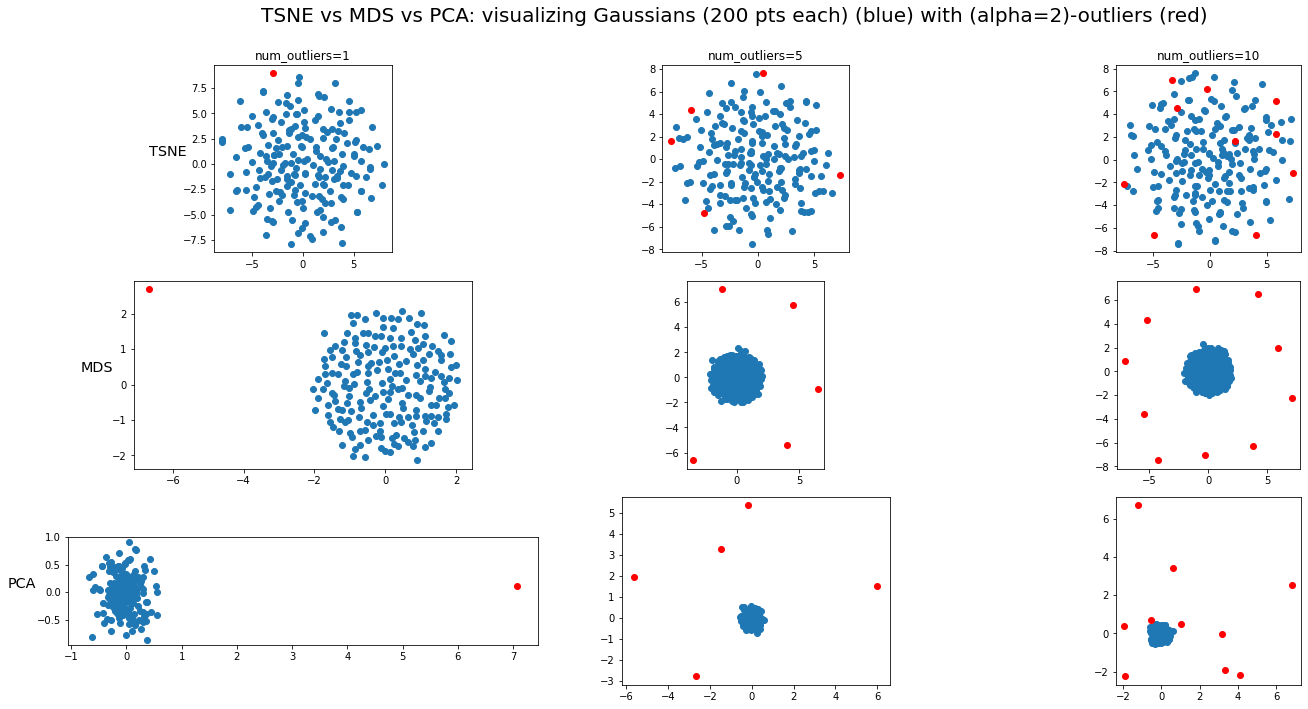

In [ ]:

percluster=200
#num_outliers = 5

X_mds1, X_pca1, X_tsne1, X_umap1, ab1 = make_outlier_vis(50, percluster, num_outliers=1,far=2)
X_mds2, X_pca2, X_tsne2, X_umap2, ab2 = make_outlier_vis(50, percluster, num_outliers=5,far=2)
X_mds3, X_pca3, X_tsne3, X_umap3, ab3 = make_outlier_vis(50, percluster, num_outliers=10,far=2)

fig, axs = plt.subplots(3,3, figsize=(20,10))

num_outliers = [1,5,10]#[1,5,10]

# TSNE
axs[0,0].scatter(X_tsne1[:-num_outliers[0], 0], X_tsne1[:-num_outliers[0], 1])
axs[0,0].scatter(X_tsne1[-num_outliers[0]:, 0], X_tsne1[-num_outliers[0]:, 1],c='r')
axs[0,0].set_aspect('equal')

axs[0,1].scatter(X_tsne2[:-num_outliers[1], 0], X_tsne2[:-num_outliers[1], 1])
axs[0,1].scatter(X_tsne2[-num_outliers[1]:, 0], X_tsne2[-num_outliers[1]:, 1],c='r')
axs[0,1].set_aspect('equal')

axs[0,2].scatter(X_tsne3[:-num_outliers[2], 0], X_tsne3[:-num_outliers[2], 1])
axs[0,2].scatter(X_tsne3[-num_outliers[2]:, 0], X_tsne3[-num_outliers[2]:, 1],c='r')
axs[0,2].set_aspect('equal')

"""# UMAP
axs[1,0].scatter(X_umap1[:-num_outliers[0], 0], X_umap1[:-num_outliers[0], 1])
axs[1,0].scatter(X_umap1[-num_outliers[0]:, 0], X_umap1[-num_outliers[0]:, 1],c='r')
axs[1,0].set_aspect('equal')

axs[1,1].scatter(X_umap2[:-num_outliers[1], 0], X_umap2[:-num_outliers[1], 1])
axs[1,1].scatter(X_umap2[-num_outliers[1]:, 0], X_umap2[-num_outliers[1]:, 1],c='r')
axs[1,1].set_aspect('equal')

axs[1,2].scatter(X_umap3[:-num_outliers[2], 0], X_umap3[:-num_outliers[2], 1])
axs[1,2].scatter(X_umap3[-num_outliers[2]:, 0], X_umap3[-num_outliers[2]:, 1],c='r')
axs[1,2].set_aspect('equal')"""

# MDS
axs[1,0].scatter(X_mds1[:-num_outliers[0], 0], X_mds1[:-num_outliers[0], 1])
axs[1,0].scatter(X_mds1[-num_outliers[0]:, 0], X_mds1[-num_outliers[0]:, 1],c='r')
axs[1,0].set_aspect('equal')

axs[1,1].scatter(X_mds2[:-num_outliers[1], 0], X_mds2[:-num_outliers[1], 1])
axs[1,1].scatter(X_mds2[-num_outliers[1]:, 0], X_mds2[-num_outliers[1]:, 1],c='r')
axs[1,1].set_aspect('equal')

axs[1,2].scatter(X_mds3[:-num_outliers[2], 0], X_mds3[:-num_outliers[2], 1])
axs[1,2].scatter(X_mds3[-num_outliers[2]:, 0], X_mds3[-num_outliers[2]:, 1],c='r')
axs[1,2].set_aspect('equal')


# PCA
axs[2,0].scatter(X_pca1[:-num_outliers[0], 0], X_pca1[:-num_outliers[0], 1])
axs[2,0].scatter(X_pca1[-num_outliers[0]:, 0], X_pca1[-num_outliers[0]:, 1],c='r')
axs[2,0].set_aspect('equal')

axs[2,1].scatter(X_pca2[:-num_outliers[1], 0], X_pca2[:-num_outliers[1], 1])
axs[2,1].scatter(X_pca2[-num_outliers[1]:, 0], X_pca2[-num_outliers[1]:, 1],c='r')
axs[2,1].set_aspect('equal')

axs[2,2].scatter(X_pca3[:-num_outliers[2], 0], X_pca3[:-num_outliers[2], 1])
axs[2,2].scatter(X_pca3[-num_outliers[2]:, 0], X_pca3[-num_outliers[2]:, 1],c='r')
axs[2,2].set_aspect('equal')



cols = ['num_outliers=1', 'num_outliers=5', 'num_outliers=10']
rows = ['TSNE', 'MDS', 'PCA']


for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, labelpad=15,rotation=0, size='x-large')

fig.tight_layout()
fig.suptitle(f'TSNE vs MDS vs PCA: visualizing Gaussians ({percluster} pts) (blue) with (alpha=2)-outliers (red)', fontsize=20)
plt.subplots_adjust(top=0.9)

plt.savefig('visuals/outlier_detection.png')



/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold

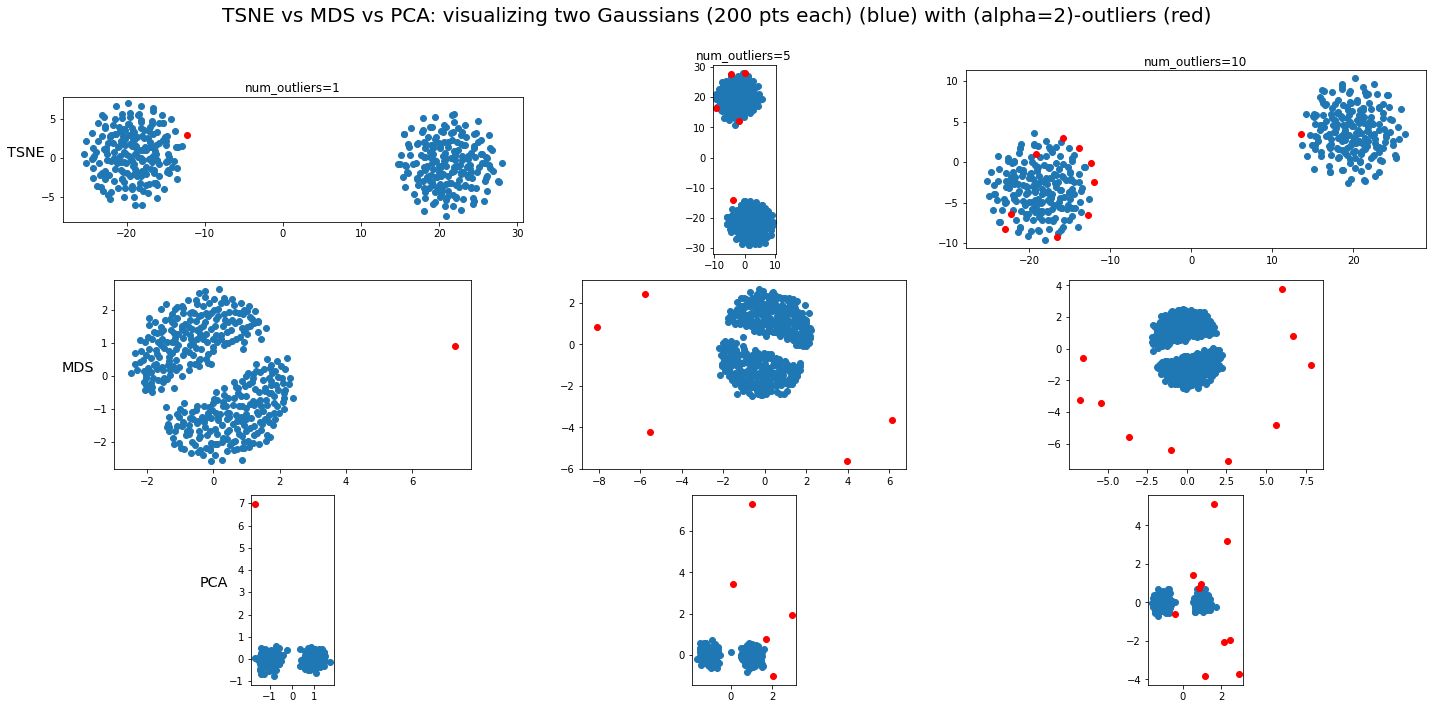

In [ ]:

percluster=200
#num_outliers = 5

X_mds1, X_pca1, X_tsne1, X_umap1, ab1 = make_outlier_vis(50, percluster, num_outliers=1,far=2, one_clust=False)
X_mds2, X_pca2, X_tsne2, X_umap2, ab2 = make_outlier_vis(50, percluster, num_outliers=5,far=2, one_clust=False)
X_mds3, X_pca3, X_tsne3, X_umap3, ab3 = make_outlier_vis(50, percluster, num_outliers=10,far=2, one_clust=False)

fig, axs = plt.subplots(3,3, figsize=(20,10))

num_outliers = [1,5,10]#[1,5,10]

# TSNE
axs[0,0].scatter(X_tsne1[:-num_outliers[0], 0], X_tsne1[:-num_outliers[0], 1])
axs[0,0].scatter(X_tsne1[-num_outliers[0]:, 0], X_tsne1[-num_outliers[0]:, 1],c='r')
axs[0,0].set_aspect('equal')

axs[0,1].scatter(X_tsne2[:-num_outliers[1], 0], X_tsne2[:-num_outliers[1], 1])
axs[0,1].scatter(X_tsne2[-num_outliers[1]:, 0], X_tsne2[-num_outliers[1]:, 1],c='r')
axs[0,1].set_aspect('equal')

axs[0,2].scatter(X_tsne3[:-num_outliers[2], 0], X_tsne3[:-num_outliers[2], 1])
axs[0,2].scatter(X_tsne3[-num_outliers[2]:, 0], X_tsne3[-num_outliers[2]:, 1],c='r')
axs[0,2].set_aspect('equal')

"""# UMAP
axs[1,0].scatter(X_umap1[:-num_outliers[0], 0], X_umap1[:-num_outliers[0], 1])
axs[1,0].scatter(X_umap1[-num_outliers[0]:, 0], X_umap1[-num_outliers[0]:, 1],c='r')
axs[1,0].set_aspect('equal')

axs[1,1].scatter(X_umap2[:-num_outliers[1], 0], X_umap2[:-num_outliers[1], 1])
axs[1,1].scatter(X_umap2[-num_outliers[1]:, 0], X_umap2[-num_outliers[1]:, 1],c='r')
axs[1,1].set_aspect('equal')

axs[1,2].scatter(X_umap3[:-num_outliers[2], 0], X_umap3[:-num_outliers[2], 1])
axs[1,2].scatter(X_umap3[-num_outliers[2]:, 0], X_umap3[-num_outliers[2]:, 1],c='r')
axs[1,2].set_aspect('equal')"""

# MDS
axs[1,0].scatter(X_mds1[:-num_outliers[0], 0], X_mds1[:-num_outliers[0], 1])
axs[1,0].scatter(X_mds1[-num_outliers[0]:, 0], X_mds1[-num_outliers[0]:, 1],c='r')
axs[1,0].set_aspect('equal')

axs[1,1].scatter(X_mds2[:-num_outliers[1], 0], X_mds2[:-num_outliers[1], 1])
axs[1,1].scatter(X_mds2[-num_outliers[1]:, 0], X_mds2[-num_outliers[1]:, 1],c='r')
axs[1,1].set_aspect('equal')

axs[1,2].scatter(X_mds3[:-num_outliers[2], 0], X_mds3[:-num_outliers[2], 1])
axs[1,2].scatter(X_mds3[-num_outliers[2]:, 0], X_mds3[-num_outliers[2]:, 1],c='r')
axs[1,2].set_aspect('equal')


# PCA
axs[2,0].scatter(X_pca1[:-num_outliers[0], 0], X_pca1[:-num_outliers[0], 1])
axs[2,0].scatter(X_pca1[-num_outliers[0]:, 0], X_pca1[-num_outliers[0]:, 1],c='r')
axs[2,0].set_aspect('equal')

axs[2,1].scatter(X_pca2[:-num_outliers[1], 0], X_pca2[:-num_outliers[1], 1])
axs[2,1].scatter(X_pca2[-num_outliers[1]:, 0], X_pca2[-num_outliers[1]:, 1],c='r')
axs[2,1].set_aspect('equal')

axs[2,2].scatter(X_pca3[:-num_outliers[2], 0], X_pca3[:-num_outliers[2], 1])
axs[2,2].scatter(X_pca3[-num_outliers[2]:, 0], X_pca3[-num_outliers[2]:, 1],c='r')
axs[2,2].set_aspect('equal')



cols = ['num_outliers=1', 'num_outliers=5', 'num_outliers=10']
rows = ['TSNE', 'MDS', 'PCA']


for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, labelpad=15,rotation=0, size='x-large')

fig.tight_layout()
fig.suptitle(f'TSNE vs MDS vs PCA: visualizing two Gaussians ({percluster} pts each) (blue) with (alpha=2)-outliers (red)', fontsize=20)
plt.subplots_adjust(top=0.9)

plt.savefig('visuals/outliers/outlier_detection_two_clust.png')



/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold

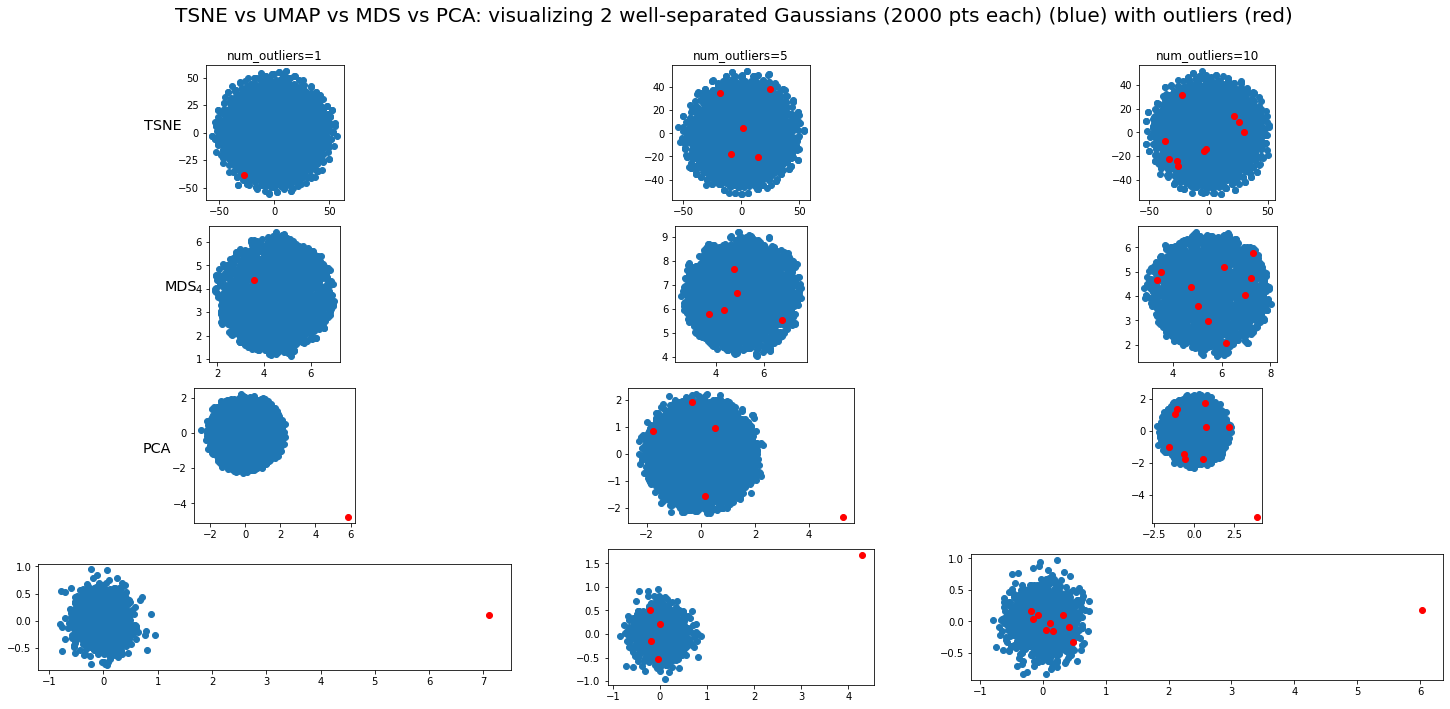

In [ ]:

percluster=2000
#num_outliers = 5

X_mds1, X_pca1, X_tsne1, X_umap1, ab1 = make_outlier_vis(50, percluster, num_outliers=1,far=5)
X_mds2, X_pca2, X_tsne2, X_umap2, ab2 = make_outlier_vis(50, percluster, num_outliers=1,far=50)
X_mds3, X_pca3, X_tsne3, X_umap3, ab3 = make_outlier_vis(50, percluster, num_outliers=1,far=500)

fig, axs = plt.subplots(4,3, figsize=(20,10))

num_outliers = [1,5,10]#[1,5,10]

# TSNE
axs[0,0].scatter(X_tsne1[:-num_outliers[0], 0], X_tsne1[:-num_outliers[0], 1])
axs[0,0].scatter(X_tsne1[-num_outliers[0]:, 0], X_tsne1[-num_outliers[0]:, 1],c='r')
axs[0,0].set_aspect('equal')

axs[0,1].scatter(X_tsne2[:-num_outliers[1], 0], X_tsne2[:-num_outliers[1], 1])
axs[0,1].scatter(X_tsne2[-num_outliers[1]:, 0], X_tsne2[-num_outliers[1]:, 1],c='r')
axs[0,1].set_aspect('equal')

axs[0,2].scatter(X_tsne3[:-num_outliers[2], 0], X_tsne3[:-num_outliers[2], 1])
axs[0,2].scatter(X_tsne3[-num_outliers[2]:, 0], X_tsne3[-num_outliers[2]:, 1],c='r')
axs[0,2].set_aspect('equal')

# UMAP
axs[1,0].scatter(X_umap1[:-num_outliers[0], 0], X_umap1[:-num_outliers[0], 1])
axs[1,0].scatter(X_umap1[-num_outliers[0]:, 0], X_umap1[-num_outliers[0]:, 1],c='r')
axs[1,0].set_aspect('equal')

axs[1,1].scatter(X_umap2[:-num_outliers[1], 0], X_umap2[:-num_outliers[1], 1])
axs[1,1].scatter(X_umap2[-num_outliers[1]:, 0], X_umap2[-num_outliers[1]:, 1],c='r')
axs[1,1].set_aspect('equal')

axs[1,2].scatter(X_umap3[:-num_outliers[2], 0], X_umap3[:-num_outliers[2], 1])
axs[1,2].scatter(X_umap3[-num_outliers[2]:, 0], X_umap3[-num_outliers[2]:, 1],c='r')
axs[1,2].set_aspect('equal')

# MDS
axs[2,0].scatter(X_mds1[:-num_outliers[0], 0], X_mds1[:-num_outliers[0], 1])
axs[2,0].scatter(X_mds1[-num_outliers[0]:, 0], X_mds1[-num_outliers[0]:, 1],c='r')
axs[2,0].set_aspect('equal')

axs[2,1].scatter(X_mds2[:-num_outliers[1], 0], X_mds2[:-num_outliers[1], 1])
axs[2,1].scatter(X_mds2[-num_outliers[1]:, 0], X_mds2[-num_outliers[1]:, 1],c='r')
axs[2,1].set_aspect('equal')

axs[2,2].scatter(X_mds3[:-num_outliers[2], 0], X_mds3[:-num_outliers[2], 1])
axs[2,2].scatter(X_mds3[-num_outliers[2]:, 0], X_mds3[-num_outliers[2]:, 1],c='r')
axs[2,2].set_aspect('equal')


# PCA
axs[3,0].scatter(X_pca1[:-num_outliers[0], 0], X_pca1[:-num_outliers[0], 1])
axs[3,0].scatter(X_pca1[-num_outliers[0]:, 0], X_pca1[-num_outliers[0]:, 1],c='r')
axs[3,0].set_aspect('equal')

axs[3,1].scatter(X_pca2[:-num_outliers[1], 0], X_pca2[:-num_outliers[1], 1])
axs[3,1].scatter(X_pca2[-num_outliers[1]:, 0], X_pca2[-num_outliers[1]:, 1],c='r')
axs[3,1].set_aspect('equal')

axs[3,2].scatter(X_pca3[:-num_outliers[2], 0], X_pca3[:-num_outliers[2], 1])
axs[3,2].scatter(X_pca3[-num_outliers[2]:, 0], X_pca3[-num_outliers[2]:, 1],c='r')
axs[3,2].set_aspect('equal')



cols = ['num_outliers=1', 'num_outliers=5', 'num_outliers=10']
rows = ['TSNE', 'MDS', 'PCA']


for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, labelpad=15,rotation=0, size='x-large')

fig.tight_layout()
fig.suptitle(f'TSNE vs UMAP vs MDS vs PCA: visualizing 2 well-separated Gaussians ({percluster} pts each) (blue) with outliers (red)', fontsize=20)
plt.subplots_adjust(top=0.9)

plt.savefig('visuals/outlier_detection.png')



<ipython-input-34-524983ef5590>:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_transformed[:-num_outliers,0], X_transformed[:-num_outliers,1], cmap=plt.cm.Spectral)
<ipython-input-34-524983ef5590>:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_transformed[-num_outliers:,0], X_transformed[-num_outliers:,1], c = 'r',cmap=plt.cm.Spectral)


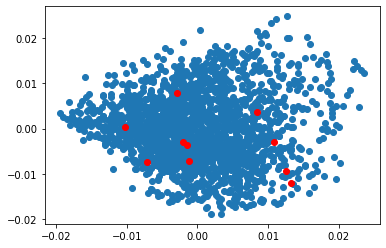

In [ ]:
from sklearn.manifold import SpectralEmbedding



embedding = SpectralEmbedding(n_components=2, n_neighbors=10)

X,y = two_gaussians_labelled(NumPointsInCluster=percluster ,distance=far, dim=dim)
    
X = X[:percluster]
y = y[:percluster]

# introducing a single outlier

#X = X[percluster+1:]
num_outliers= 10
for i in range(num_outliers):
    far = 100
    random_vector = np.random.normal(size=dim)
    unit_vector = diam(X)*(far)*random_vector / np.linalg.norm(random_vector)
    X = np.concatenate((X, np.array([random_vector])), axis=0)


X_transformed = embedding.fit_transform(X)

plt.scatter(X_transformed[:-num_outliers,0], X_transformed[:-num_outliers,1], cmap=plt.cm.Spectral)
plt.scatter(X_transformed[-num_outliers:,0], X_transformed[-num_outliers:,1], c = 'r',cmap=plt.cm.Spectral)
